# Data preparation and ingestion

In [1]:
# Imports
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from elasticsearch import Elasticsearch
from statistics import median
from sentence_transformers import SentenceTransformer
import pickle
import matplotlib.pyplot as plt
import torch
import h5py

/usr/local/python/3.12.1/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load the data

In [2]:
# Load in Pandas df
data_path = "../data/ancient_sources.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
df.head()

,author,title,section,text
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...


In [3]:
# Check size
df.shape

(111709, 4)

## Data cleaning and EDA

In [4]:
# Append index as ID
df['Id'] = df.index

In [5]:
# Delete rows without text
df.drop(df[df["text"].isna()].index, inplace=True)

# Transform rows with NaN section to ""
df['section'] = df['section'].fillna("")

In [6]:
# Check new size
df.shape

(111707, 5)

In [7]:
# Create a function that counts number of words of a text
def count_words(text):
    return len(text.split())

# Append a column with the number of words of the texts
df["num_words"] = df["text"].apply(count_words)

# Show first rows
df.head()

,author,title,section,text,Id,num_words
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...,0,445
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...,1,357
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...,2,279
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...,3,349
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...,4,554


In [8]:
df["num_words"].describe()

count    111707.000000
mean        179.352252
std         367.455390
min           1.000000
25%          58.000000
50%          94.000000
75%         173.000000
max       31177.000000
Name: num_words, dtype: float64

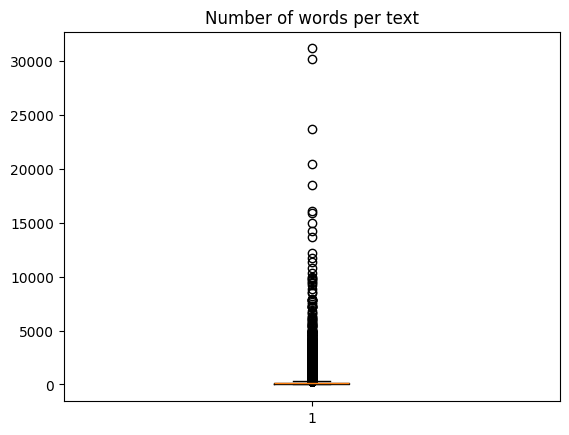

In [9]:
# Boxplot
boxplot_stats = plt.boxplot(df['num_words'])
plt.title('Number of words per text');

In [10]:
whiskers = [item.get_ydata() for item in boxplot_stats['whiskers']]
upp_whisker = whiskers[1][1]
print("Upper whisker:", upp_whisker)

Upper whisker: 345.0


In [11]:
df[df["num_words"] > 512].shape

(7786, 6)

The upper limit stablished by boxplot is 345 words, so let's cut all the texts with a number of words higher than 512 (a bit higher than the boxplot upper limit). With this change, more of the 90% of the text will remain with the full text. Hopefully, this will make the embbeding calculation ligther.

In [12]:
# Define function that truncates the longer texts
def truncate_texts(text, max_num_words=512):
    word_list = text.split()
    if len(word_list) > max_num_words:
        word_list = word_list[:max_num_words]

    return " ".join(word_list)

# Apply to all the texts
df["text"] = df["text"].apply(truncate_texts)

# Count again the num of words
df["num_words"] = df["text"].apply(count_words)

# Check df
df.head()

,author,title,section,text,Id,num_words
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...,0,445
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...,1,357
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...,2,279
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...,3,349
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...,4,512


In [13]:
# Check statistics again
df["num_words"].describe()

count    111707.000000
mean        148.231821
std         143.268450
min           1.000000
25%          58.000000
50%          94.000000
75%         173.000000
max         512.000000
Name: num_words, dtype: float64

In [14]:
# Drop number of words column
df.drop('num_words', axis=1, inplace=True)

## Generate embeddings for vector search

We are going to use *msmarco-roberta-base-ance-firstp* model, which is well suited for long passages of text and is fine-tunned for dot product similarity, which is usually preferred for long passages of text (our case). Also, it is optimized for ANCE (Approximate Nearest Neighbor Search). Later, we will have to take all this into account by configuring Elasticsearch k-NN to use dot product and Approximate Nearest Neighbor Search.

In [15]:
# Transform into a list of dicts
df_dict = df.to_dict(orient="records")

# Generate list with all the texts
texts_list = [source["text"]for source in df_dict]

In [18]:
# Load the msmarco-roberta-base-ance-firstp
# model = SentenceTransformer('msmarco-roberta-base-ance-firstp')

# Load it for GPU exec
model = SentenceTransformer('msmarco-roberta-base-ance-firstp', device='cuda')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/744 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

3_LayerNorm/config.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

3_LayerNorm/model.safetensors:   0%|          | 0.00/6.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/7.14k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# Check for GPU availability
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Count: {torch.cuda.device_count()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: Tesla T4


In [21]:
# Compute embeddings
embeddings = model.encode(texts_list, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/3491 [00:00<?, ?it/s]

In [ ]:
# Save embeddings
with h5py.File('../data/embeddings.h5', 'w') as hf:
    hf.create_dataset('embeddings', data=embeddings, compression='gzip', compression_opts=9)

In [17]:
!ls -ltra ../data

total 353228
drwxrwxrwx+ 5 codespace root           4096 Sep  6 06:55 ..
-rw-rw-rw-  1 codespace codespace  46743161 Sep  6 06:55 ancient_sources.csv.gz
drwxrwxrwx+ 2 codespace codespace      4096 Sep  6 06:57 .
-rw-rw-rw-  1 codespace codespace 314946082 Sep  6 07:01 embeddings.h5


In [18]:
# Load embeddings
with h5py.File('../data/embeddings.h5', 'r') as hf:
    dataset = hf['embeddings']
    
    # Load the data into a NumPy array
    embeddings = dataset[:]

In [21]:
# Append embeddings to the corresponding sources
for i, source in enumerate(df_dict):
    source["text_embedding"] = embeddings[i]

In [23]:
# Show example
df_dict[1]

{'author': 'Euripides',
 'title': 'Ion',
 'section': 'lines 1-40',
 'text': "Before the Temple of Apollo at Delphi . The sun is about to rise. Hermes enters. Hermes Hermes Atlas, who wears away heaven, the ancient home of the gods, on his bronze shoulders, was the father of Maia by a goddess; she bore me, Hermes, to great Zeus; and I am the gods' servant. I have come to Delphi , this land where Phoebus from his central throne chants to mortals, always declaring the present and the future. For Hellas has a famous city, which received its name from Pallas of the golden lance; here Apollo forced a union on Creusa, the child of Erechtheus, where the rocks, turned to the north beneath the hill of Pallas' Athenian land, are called Macrai by the lords of Attica . Unknown to her father —such was the pleasure of the god— she bore the weight in her womb. When the time came, Creusa gave birth in the house to a child, and brought the infant to the same cave where the god had bedded her, and there 